# Wine Quality Prediction project

The goal of this project is to build a model to predict the quality of a bottle of wine based on the wine's physical and chemical attributes.

This is a supervised learning task that can be approached as a classification or regression problem because we have an ordinal response variable with 7 possible labels.  We will implement several classification and regression models (Random Forest and Support Vector) and compare their performance.  We also seek to implement a Linear Regression Model, but that is contingent upon meeting the proper assumptions and conditions.


---
### Libraries and utility functions

In [278]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
# hide "future warnings"
import warnings; warnings.filterwarnings('ignore')

%matplotlib inline

In [279]:
# A function to improve notebook readability by plotting and formatting predictor visualizations with a single call
def plot_predictor_vis(df, predictor_name_string):
    sns.set_style("darkgrid")
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
    plt.suptitle(predictor_name_string)
    sns.histplot(df, x=predictor_name_string, ax=ax1)
    sns.boxplot(x="quality", y=predictor_name_string, data=df, ax=ax2)
    plt.show()

In [280]:
def tolerance(y_pred, y_true, t):
    """
    adjusts predicted values based on proximity to true label.
    :param t: tolerance

    when |y_pred - y_true| <= t:
        y_pred is set to equal y_true
            this represents a "correct" prediction that is within the specified tolerance
    when |y_pred - y_true| > t:
        y_pred is set to the nearest integer that does not equal y_true
            this represents an "incorrect" prediction that is outside of the specified tolerance
    """
    y_pred_tol = np.zeros(len(y_pred))
    for i in range(len(y_pred)):
        #case when prediction is within tolerance
        if np.abs(y_pred[i] - y_true.values[i]) <= t:
            y_pred_tol[i] = y_true.values[i]

        #case when prediction is outside of tolerance
        else:
            if np.round(y_pred[i]) != y_true.values[i]:
                y_pred_tol[i] = np.round(y_pred[i])
            elif np.floor(y_pred[i]) == y_true.values[i]:
                y_pred_tol[i] = np.ceil(y_pred[i])
            elif np.ceil(y_pred[i]) == y_true.values[i]:
                y_pred_tol[i] = np.floor(y_pred[i])

    return y_pred_tol

In [281]:
# A function to improve notebook readability by plotting and formatting confusion matrices with a single call
def plot_cm(y_test, y_adj, supertitle):
    sns.set_style("dark")
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,4)); plt.suptitle(supertitle)
    ConfusionMatrixDisplay.from_predictions(y_test, y_adj, ax=ax1); ax1.set_title("Confusion Matrix: raw")
    ConfusionMatrixDisplay.from_predictions(y_test, y_adj, normalize="pred", ax=ax2); ax2.set_title("normalized by pred")
    ConfusionMatrixDisplay.from_predictions(y_test, y_adj, normalize="true", ax=ax3); ax3.set_title("normalized by true")
    plt.show()

---
# Import dataset

Data Source:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In *Decision Support Systems*, Elsevier, 47(4):547-553, 2009.

https://doi.org/10.1016/j.dss.2009.05.016

In [282]:
white_wine_url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(white_wine_url, sep=";")
df.columns = ["fixed_acid", "volatile_acid", "citric_acid", "residual_sugar", "chlorides",
              "free_SO2", "total_SO2", "density", "pH", "sulphates", "alcohol", "quality"]
print(f'White Wine DataFrame shape: \n {df.shape}')
df.describe()

White Wine DataFrame shape: 
 (4898, 12)


,fixed_acid,volatile_acid,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


---
# Data description

This dataset includes 11 features and 1 label (`quality`) for each of 4898 white wines (rows).  All features are numeric data.  There are no missing values.  `Quality` is an ordinal variable represented with integer values, but there is no need to convert it from the `float` data type.

The response variable is `Quality`.  It represents the median score on a scale of 0(worst) to 10(best) as rated by a panel of 3+ judges who are considered experts.

The predictor variables are each chemical or physical properties that are relatively easy to measure.  Even a neophyte is likely to recognize some of the predictors such as alcohol level, density, and pH.  Other predictors may be recognizable under different names.  For example, "volatile acidity" is vinegar and "chlorides" is mostly a measure of NaCl (salt).

Note that the range of the features differ by several order of magnitude.  We'll need to account for this (by scaling the data) when using algorithms that consider euclidean distances.

---
# Quality (response variable)

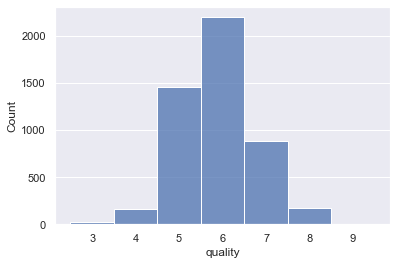

Quality 
value count
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5


In [283]:
sns.set_style("dark")
ax = sns.histplot(df, x="quality", discrete=True)
ax.yaxis.grid(True)
plt.show()
print(f"Quality \nvalue count\n{df.quality.value_counts().sort_index(ascending=True).to_string()}")

The histogram reveals that our response variable, `quality`, is distributed in an approximately normal manner (many average wines; few excellent or terrible wines).  Therefore, our labels are severely imbalanced.  Many classification algorithms would struggle to correctly classify wines with the less common labels.  For example, a KNN model would require many modifications to correctly label any of the less common labels.

A regression approach may be able to take advantage of the natural ordering between labels, and may be better suited for labeling wines that have uncommonly good or bad quality scores.

The severe imbalance between labels means that we need to thoughtfully select our evaluation metrics, since 3 of the 7 labels contain 92.5% of the wines!  Additionally, the uncommon labels happen to represent the wines that would be the *most* important to a client!  To address these difficulties caused by the imbalanced labels, we will evaluate our models by their weighted F1 score as well as considering the performance for each label separately.

---
# Predictor variable exploration

The data is already cleaned in the sense that there are no missing values or incorrect datatypes, **but** we still need to take a closer look at the predictors for several reasons.  I would like to use a linear regression model if possible, because the interpretability of such a model would be a huge plus.  But a linear model is a poor choice if assumptions and conditions such as a linearity, normality of residuals, and homoscedasticity  are violated.

We'll also check for evidence of collinearity. There are biochemical and/or physical reasons to suspect that some of the predictors should be highly correlated.  In particular, many of these predictors are involved in the same biochemical pathways.  For example, pH should be strongly related to the levels of the 3 organic acids (fixed, volatile, and citric) because those acids directly determine acidity.  Likewise, alcohol and density should be strongly correlated because water and alcohol have different densities and they are by far the most prevalent molecules by volume.

After this exploration, we will have a better idea of whether a linear model may be appropriate.  Regardless, we should be able to successfully use Random Forest and Support Vector classification and regression models since they are far more robust in the face of collinearity and deviations from linearity.

Finally, we'll look for the presence of outliers within the predictors.  Random Forest and Support Vector models are robust against all but the most egregious outliers, but outliers will have a larger influence on a Linear Regression Model.  However, we also need to consider that our dataset is already highly imbalanced.  Removing outliers from the least common labels could have an enormous effect.  One option is to consider entirely eliminating problematic predictors if the predictor is strongly correlated with a "cleaner" set of variables.

### Assessing collinearity

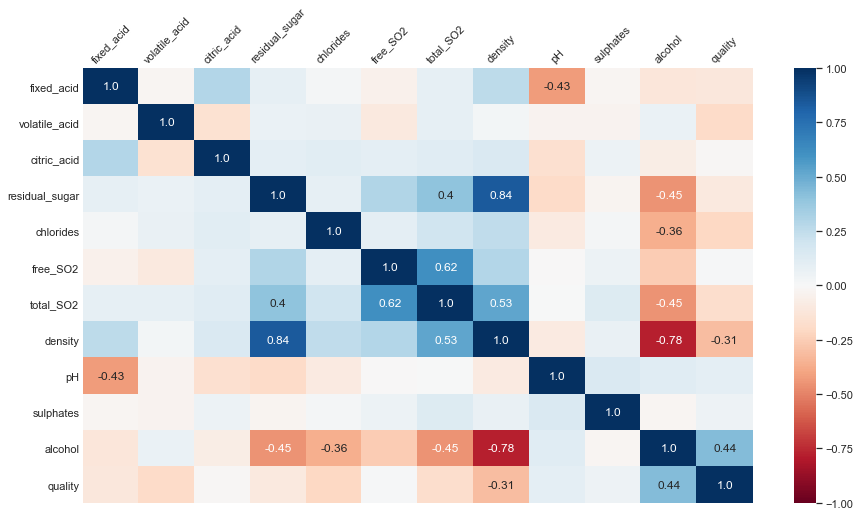

In [284]:
#custom labeling to hide small correlation coefficients
corr_labs = df.corr()
for col in corr_labs.columns:
    corr_labs[col] = corr_labs[col].apply(lambda x: "" if x <=.3 and x >= -.3 else str(round(x,2)))

# create and display correlation matrix heatmap
sns.set(rc = {'figure.figsize':(15,8)})
heatmap = sns.heatmap(df.corr(),
                      annot=corr_labs,
                      fmt="",
                      cmap="RdBu",
                      vmax=1, vmin=-1, center=0)
heatmap.xaxis.tick_top()
heatmap.tick_params(length=0)
plt.xticks(rotation = 45)
plt.show()

Some of these correlations are large enough to suggest that I was right to expect collinearity among predictors.  We should take a look at VIFs to get a clearer idea of which features need to be removed in order to properly implement a Linear Regression Model.



In [285]:
# calculate VIF in order to detect multi-collinearity
design_matrix = add_constant(df.drop(columns="quality"), prepend=True)
vif=pd.Series([variance_inflation_factor(design_matrix.values, i) for i in range(design_matrix.shape[1])],
              index=design_matrix.columns)
print(np.round(vif,2).to_string())

const             3067855.57
fixed_acid              2.69
volatile_acid           1.14
citric_acid             1.17
residual_sugar         12.64
chlorides               1.24
free_SO2                1.79
total_SO2               2.24
density                28.23
pH                      2.20
sulphates               1.14
alcohol                 7.71



With a VIF of 28.23, `Density` should be dropped if we're going to implement a Linear Model.  `Residual_sugar` and `alcohol` are also concerning, but removing `density` may fix the problem.  In addition to having the largest VIF, `density` is a reasonable candidate for removal for domain-knowledge reasons.  `Density` is a function of the wine's chemical composition and is heavily, directly influenced by `alcohol` content.

Still, `density` incorporates information about the wine's chemical composition that was not directly measured by another predictor variable, so we won't drop it from the dataset unless if it is required for the sake of fitting a Linear Model.


---
### Predictor Visualizations

Reminder: We are looking for outliers (that are "safe" to remove) as well as evidence that the assumptions for a Linear Model are fulfilled.

---
### Residual Sugar

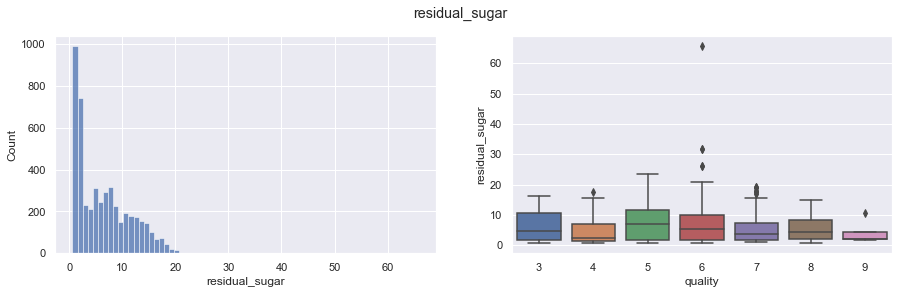

In [286]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_style("darkgrid")
plot_predictor_vis(df,"residual_sugar")

We can remove the `residual_sugar` outlier since it is labeled as a 6, which is an incredibly common, middle of the pack score.  It is fair to consider this wine an outlier because its `residual_sugar` is double the next largest value and almost 10 times larger than the mean value.


In [287]:
#drop the row that has the residual_sugar outlier
ol_residual_sugar = df[df.residual_sugar >40]
df = df.drop(index=ol_residual_sugar.index)
print(f"new shape: {df.shape}")

new shape: (4897, 12)


---
### Free sulphur dioxide

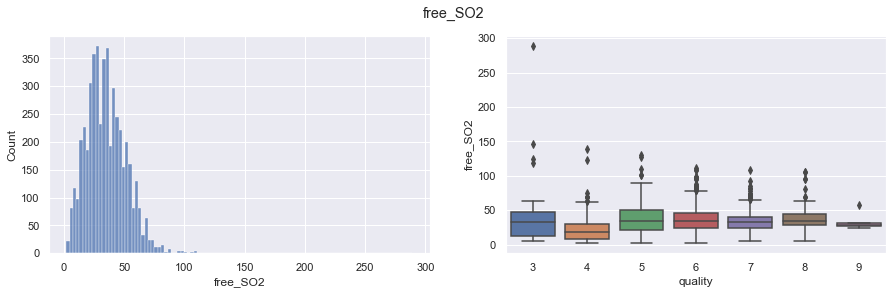

In [288]:
plot_predictor_vis(df, "free_SO2")


We won't remove any potential outliers based on `free_SO2` because we are reluctant to remove any wines labeled 3.  Also, it is entirely reasonable that a wine with high levels of sulphur dioxide would be very poor quality.

---
### Fixed acidity (tartaric acid)

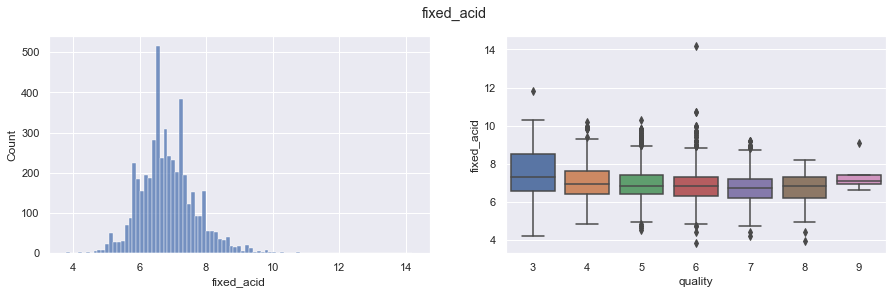

In [289]:
plot_predictor_vis(df, "fixed_acid")

In [290]:
#drop the row with the fixed_acid outlier
ol_fixed_acid = df[df.fixed_acid > 12]
df = df.drop(index=ol_fixed_acid.index)
print(f"new shape: {df.shape}")

new shape: (4896, 12)


---
### Volatile acidity (vinegar)

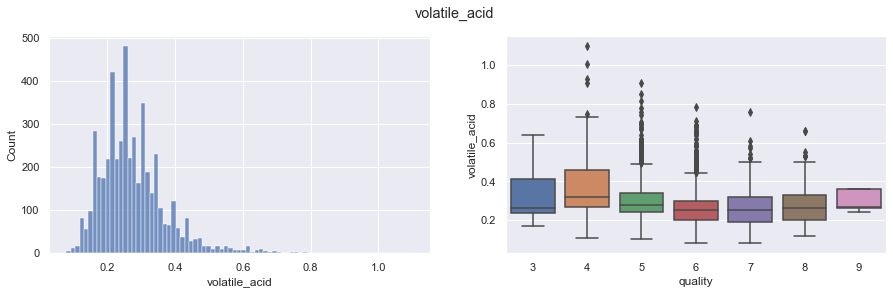

In [291]:
plot_predictor_vis(df, "volatile_acid")

---
### Citric acid

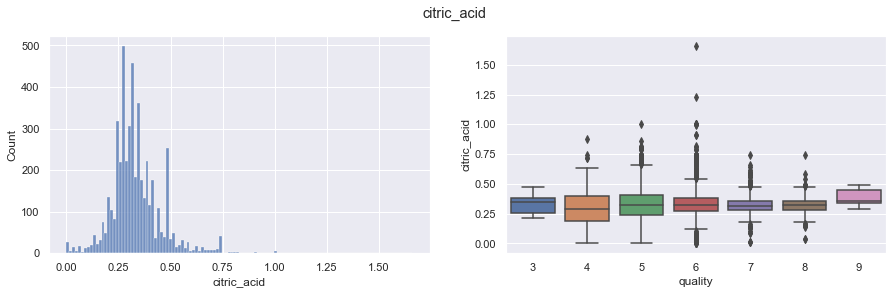

In [292]:
plot_predictor_vis(df, "citric_acid")

In [293]:
#remove citric acid outliers
ol_citric_acid = df[df.citric_acid > 1.5]
df = df.drop(index=ol_citric_acid.index)
print(f"new shape: {df.shape}")

new shape: (4895, 12)


---
### Chlorides (sodium chloride)

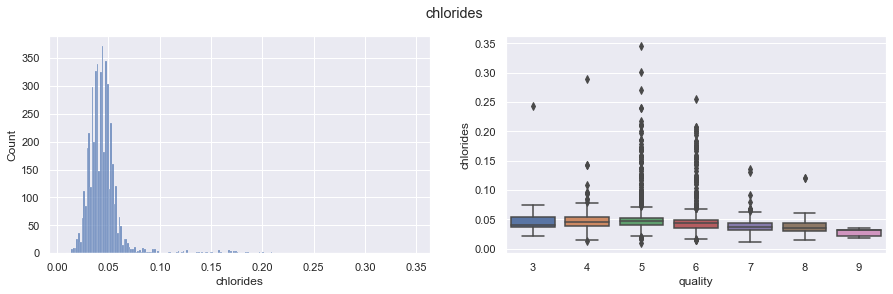

In [294]:
plot_predictor_vis(df, "chlorides")

---
### Total sulphur dioxide

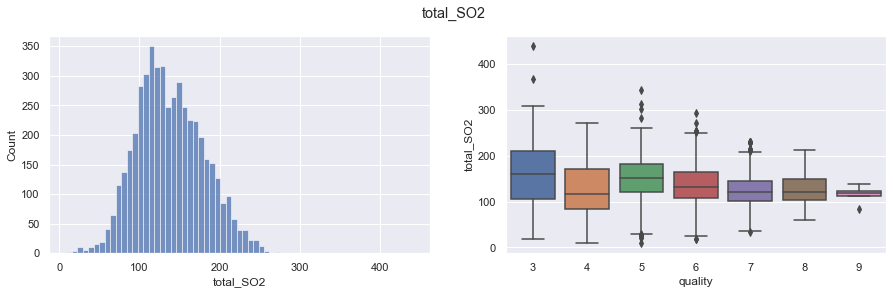

In [295]:
plot_predictor_vis(df, "total_SO2")

As with `free_SO2`, we won't touch any of these possible outliers because the worst offenders belong to poor-quality wines, which suggests that they depict an important relationship between very high sulphur-dioxide levels and bad wine quality.

---
# Density

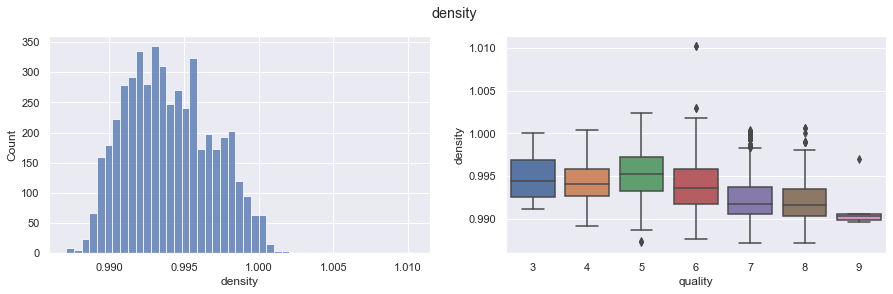

In [296]:
plot_predictor_vis(df, "density")


---
### pH

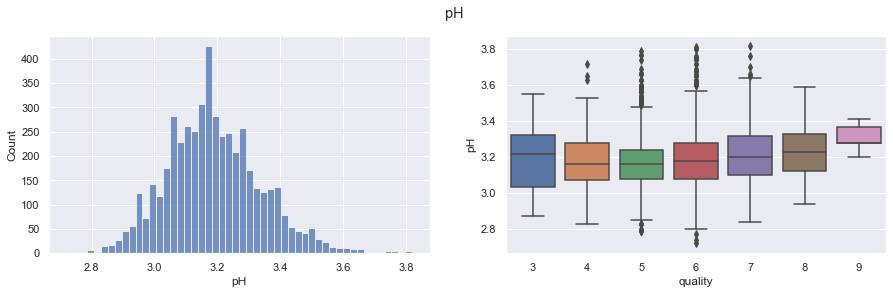

In [297]:
plot_predictor_vis(df, "pH")

---
### Sulphates (potassium sulphate)

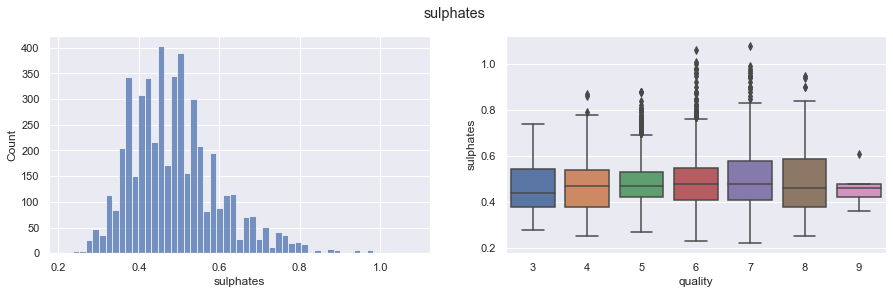

In [298]:
plot_predictor_vis(df, "sulphates")

---
### Alcohol (vol.%)

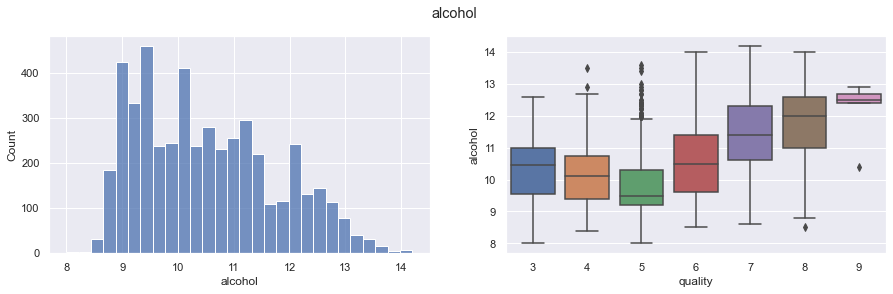

In [299]:
plot_predictor_vis(df, "alcohol")

It is worth noting that `alcohol` appears to have the strongest relationship between predictor and response out of all our predictors.

### Predictor exploration summary

Overall, a Linear Model does not appear appropriate for this dataset.  Few of the predictors indicate a linear (or easily transformable) relationship with `quality`.  Homoscedasticity also appears likely to be violated.  While it is possible that we could creatively transform the predictors or make a performant GAM, we would sacrifice interpretability by doing so. Interpretability was the main selling point of attempting linear regression in the first place, so we'll ditch that idea and focus on the Random Forest and Support Vector models instead.  Therefore, we don't need to drop `density`

---
# Clustering

All of the wines in the dataset are white wines, but many styles of white wines exist.  Within each style, different characteristics are valued.  Before we begin our modeling, it is worth taking the time to see if we can identify clusters of wines that may represent alternative styles.  If we find such clusters, we may be able to leverage that to improve the predictive ability of our models.  To check for well defined clusters that would represent wine styles, we'll use the K-means algorithm which is appropriate for our (potentially) unlabeled data.

At each value of `k` we will calculate the silhouette coefficient.  The silhouette coefficient is in the range [-1,1] with 1 indicating strong separation between clusters.

In [300]:
#split predictors from response
X, y = df.drop(columns = "quality"), df["quality"]
print(f" X: {X.shape} \n y: {y.shape}")

#Scale the predictors
scaler = MinMaxScaler().fit(X=X)
X_std = scaler.transform(X)
#convert newly scaled predictors back into a dataframe with correct column names
X_std = pd.DataFrame(X_std, columns = X.columns)

 X: (4895, 11) 
 y: (4895,)


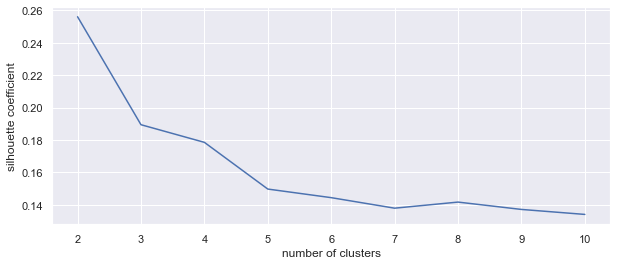

In [301]:
#fit clusters for different Ks, and compare their silhouette scores.  scores can range from [-1,1].  +1 indicates best possible clustering
sns.set_style("darkgrid")
k_clusters = []
k_max = 10
for k in range(2, k_max+1):
    kth_cluster = KMeans(n_clusters=k, random_state=1).fit_predict(X_std)
    k_clusters.append( (k, kth_cluster) )

sils = []
ks = []
for t in k_clusters:
    ks.append(t[0])
    sils.append(silhouette_score(X_std, t[1]))

sil_df = pd.DataFrame({"ks":ks, "sils":sils})
sns.lineplot(sil_df.ks, sil_df.sils)
plt.xlabel("number of clusters"); plt.ylabel("silhouette coefficient")
plt.show()

The K-Means clustering algorithm did not result in well defined clusters (which would be closer to +1).

Overall, this is sufficient evidence that we needn't worry about mixed, unlabeled wine categories in the dataset.

---
# Models

We will try classification and regression models.  Models will primarily be evaluated by weighted F1 score.

For the regression models, we need to transform the raw predictions so that they match a valid label (integers 3-9).  Instead of rounding, we will use the concept of tolerance.

**Tolerance** is the maximum distance away from the true label that a raw prediction would be considered a "correct."  For example, with tolerance = 0.5, a raw prediction of 6.25 would be considered correct if the true label was 6.  Tolerance = 0.5 can be considered identical to rounding in this case.  With tolerance = 1.0, a raw prediction of 6.25 would be considered correct if the true label was a 6 *or* 7.

Regression and Classification are best compared when tolerance = 0.5

# Test/Train split

In [302]:
y = df.quality
X = df.drop(columns="quality")
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
print(f" df: {df.shape} \n X_train: {X_train.shape} \n X_test: {X_test.shape} ")

 df: (4895, 12) 
 X_train: (3916, 11) 
 X_test: (979, 11) 


---
# Random Forest Regressor (RFR)


In [303]:
rfr = RandomForestRegressor(n_estimators=300, random_state=1)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

In [304]:
# Calculate weighted F1 vs. tolerance for later use on the REC curve plot
rec_t = np.arange(0,2.1,.1)
rfr_score = np.zeros(len(rec_t))

for i, t in enumerate(rec_t):
    y_pred = tolerance(rfr_pred, y_test, t=t)
    rfr_score[i] = f1_score(y_test, y_pred, average="weighted", zero_division=1)

#save RFR's weighted F1 vs. tolerance in DataFrame
df_rfr_rec = pd.DataFrame({"T":rec_t, "F1 score":rfr_score})
# print RFR's weighted F1 at our 2 key tolerances: 0.5 and 1.0
print(f"Random Forest Regressor \n {df_rfr_rec[5:11:5].to_string(index=False)}")

Random Forest Regressor 
    T  F1 score
 0.5  0.660271
 1.0  0.914604


---
# Random Forest Classifier (RFC)


In [305]:
rfc = RandomForestClassifier(n_estimators=300, random_state=1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(f'Random Forest Classifier \n F1 = {round(f1_score(y_test, rfc_pred, average="weighted", zero_division=1),6)}')

Random Forest Classifier 
 F1 = 0.683798


---
# Support Vector Regressor (SVR)

Before fitting a Support Vector model, we need to scale the data.  Scikit-learn's documentation recommends using the StandardScaler for best performance with the rbf kernel.

In [306]:
# First off, scale the data so it's ready for the SVR
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X.columns)
print(f" X_train_scaled: {X_train_scaled.shape} \n X_test_scaled: {X_test_scaled.shape}")

 X_train_scaled: (3916, 11) 
 X_test_scaled: (979, 11)


In [307]:
# define a custom scorer for the GridSearchCV
### This scorer returns weighted f1 score with tolerance=0.5
def t05_scorer(y_true, y_pred_raw):
    y_pred_adj = tolerance(y_pred_raw, y_true, t=0.5)
    score = f1_score(y_true, y_pred_adj, average="weighted", zero_division=0)
    return score

scorer_f1 = make_scorer(t05_scorer, greater_is_better=True)

Note: the GridSearchCV cell is commented out because it takes a while to run.  The optimal hyperparameters are saved in their own cell for the sake of performance.

In [308]:
##Note: this cell is commented out because it takes a while to run.  The results are saved in the following cell

# # GridSearchCV to determine optimal C and gamma values for our SVR; scored by weighted f1 score with tolerance = 0.5
# c_range = np.logspace(start=-2, stop=3, num=20, endpoint=True, base=2)
# gamma_range = np.logspace(start=-4, stop=4, num=20, endpoint=True, base=2)
#
# params = {"C":c_range.tolist(),
#           "gamma":gamma_range.tolist()}
# grid_f1 = GridSearchCV(SVR(kernel="rbf"),
#                         param_grid=params,
#                         scoring=scorer_f1,
#                         n_jobs=-1,
#                         cv=5)
# grid_f1.fit(X_train_scaled, y_train)
# print(f" best score: {grid_f1.best_score_} \n best estimator: {grid_f1.best_estimator_}")
#
# svr_f1=grid_f1.best_estimator_
# svr_f1_pred = svr_f1.predict(X_test_scaled)

In [309]:
# saved the best configuration from the previous gridsearch so it doesn't have to run each time.
svr_f1 = SVR(C=3.333, gamma=0.645, kernel="rbf").fit(X_train_scaled, y_train)
svr_f1_pred = svr_f1.predict(X_test_scaled)

In [310]:
# Calculate weighted F1 vs. tolerance for later use on the REC curve plot
rec_t = np.arange(0,2.1,.1)
svr_f1_score = np.zeros(len(rec_t))

for i, t in enumerate(rec_t):
    y_pred = tolerance(svr_f1_pred, y_test, t=t)
    svr_f1_score[i] = f1_score(y_test, y_pred, average="weighted", zero_division=1)

#save SVR's weighted F1 vs. tolerance in DataFrame
df_svr_f1_rec = pd.DataFrame({"t":rec_t, "F1 score":svr_f1_score})
# print SVR's weighted F1 at our 2 key tolerances: 0.5 and 1.0
print(f"Support Vector Regressor \n(optimized for t=0.5) \n {df_svr_f1_rec[5:11:5].to_string(index=False)}")

Support Vector Regressor 
(optimized for t=0.5) 
    t  F1 score
 0.5  0.663063
 1.0  0.884492


# Support Vector Classifier (SVC)

In [311]:
# #Note: this cell is commented out because it takes a while to run.  The results are saved in the following cell

# # custom scoring function for the gridsearch
# scorer_svc=make_scorer(f1_score, average="weighted", zero_division=0)
# # parameters for Gridsearch
# c_range = np.logspace(start=-1, stop=3, num=15, endpoint=True, base=2)
# gamma_range = np.logspace(start=-1, stop=5, num=20, endpoint=True, base=2)
#
# grid_svc = GridSearchCV(SVC(kernel="rbf"),
#                         param_grid={"C":c_range.tolist(),
#                                     "gamma":gamma_range.tolist()},
#                         scoring = scorer_svc,
#                         n_jobs = -1,
#                         cv=5)
# grid_svc.fit(X_train_scaled, y_train)
# print(f"When tolerance = 0.5 ... \n best score: {grid_svc.best_score_} \ best estimator: {grid_svc.best_estimator_}")
# svc = grid_svc.best_estimator_
# svc_pred = svc.predict(X_test_scaled)

In [312]:
# saved the best parameter configuration from the previous gridsearch so it doesn't have to run each time.
svc=SVC(C=2.972, gamma=0.775, kernel="rbf").fit(X_train_scaled, y_train)
svc_pred = svc.predict(X_test_scaled)

---
# Results

### Classifiers and Regressors with tolerance = 0.5

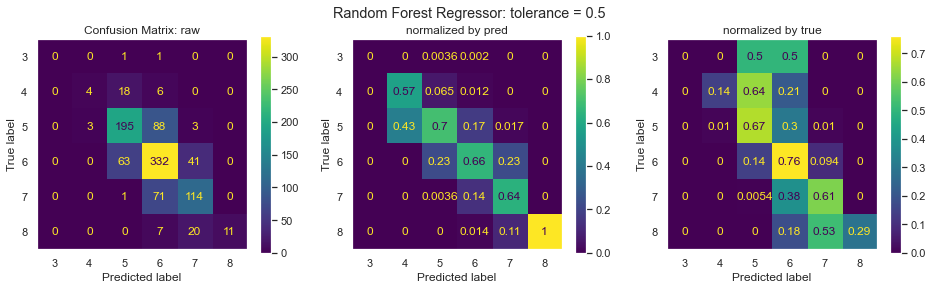

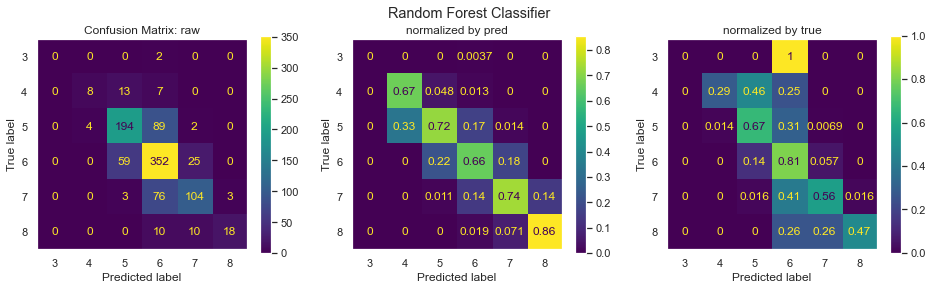

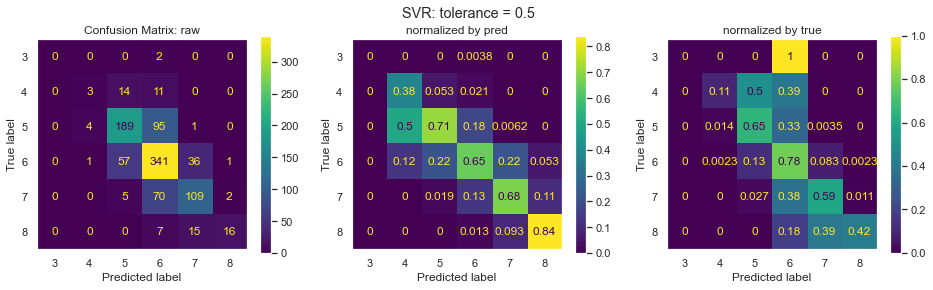

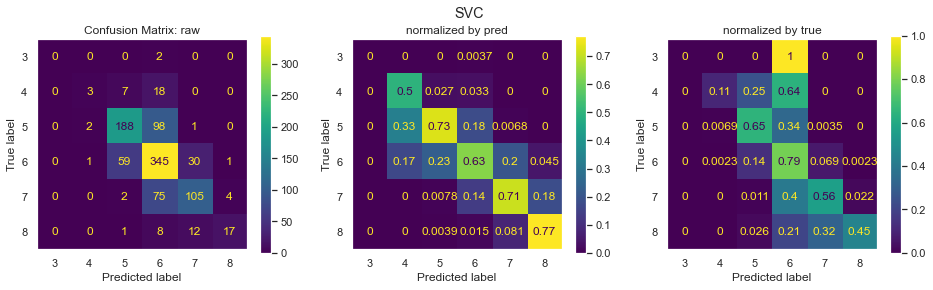

In [313]:
#Plot confusion matrices for RFR with tolerance = 0.5
plot_cm(y_test, y_adj=tolerance(rfr_pred, y_test, t=0.5), supertitle="Random Forest Regressor: tolerance = 0.5")
#Plot confusion matrices for RFC
plot_cm(y_test, rfc_pred, supertitle="Random Forest Classifier")
# Plot confusion matrices for SVR (optimized for F1) at tolerance = 0.5
plot_cm(y_test, y_adj=tolerance(svr_f1_pred, y_test, t=0.5), supertitle="SVR: tolerance = 0.5" )

#Plot confusion matrices for SVC
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,4)); plt.suptitle("SVC")
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred, ax=ax1); ax1.set_title("Confusion Matrix: raw")
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred, normalize="pred", ax=ax2); ax2.set_title("normalized by pred")
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred, normalize="true", ax=ax3); ax3.set_title("normalized by true")
plt.show()

Of these four models, the RFC is the best suited for our task.  The RFC has the largest weighted F1 score and it's precision is among the best for the most crucial labels (4,7,and 8).  The SVC has similar performance for labels 5-8, but does a terrible job at identifying the lowest quality wines.

# Tolerance = 1.0

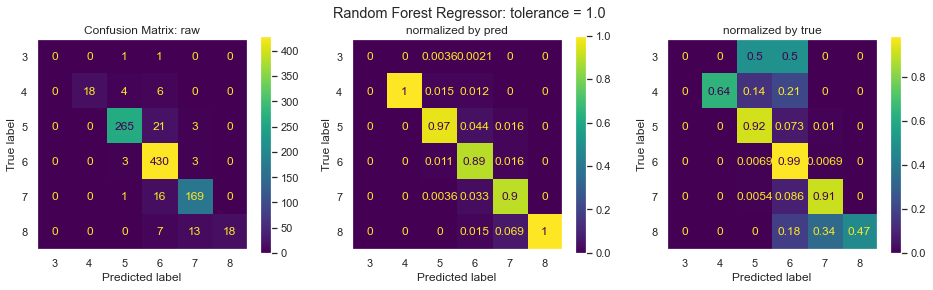

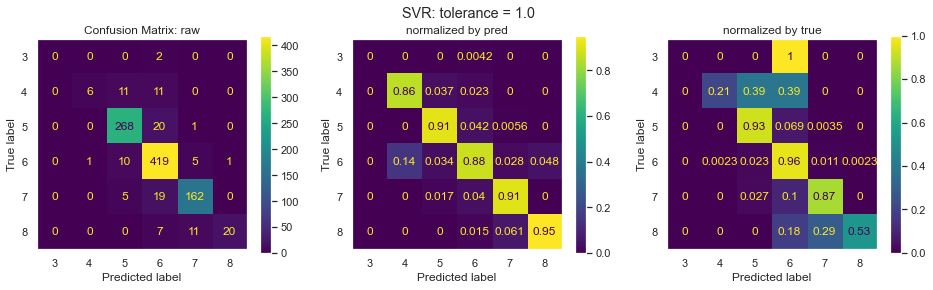

In [314]:
#Plot confusion matrices for RFR with tolerance = 1.0
plot_cm(y_test, y_adj=tolerance(rfr_pred, y_test, t=1.0), supertitle="Random Forest Regressor: tolerance = 1.0")
#Plot confusion matrices for SVR (optimized for F1) at tolerance = 1.0
plot_cm(y_test, y_adj=tolerance(svr_f1_pred, y_test, t=1.0), supertitle="SVR: tolerance = 1.0" )

If we allow a tolerance of 1.0, both regressor models outperform both classifiers.  The RFR is particularly strong under this condition since it has excellent precision for the most important labels.  The RFR's recall isn't great at the extremes, but it's acceptable given the context of our prediction task.

---
# Regression Error Characteristic chart

The following chart is a method of comparing regression models under the full range of possible tolerance values.  Although a Regression Error Characteristic chart only makes sense for regression models, I included the classifiers for the sake of comparison.  The classifiers' F1 scores are plotted at t=0.5 because that tolerance is the most directly comparable.

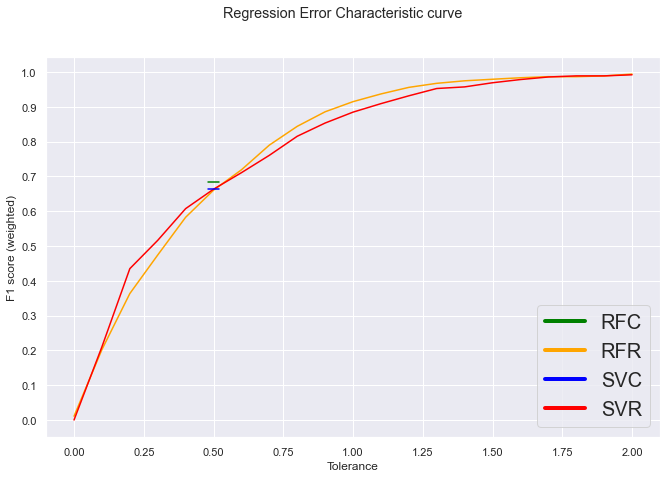

In [315]:
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(11,7)})
# REC Curve visualization
ax_rec = sns.lineplot(x=rec_t, y=rfr_score, color="orange")
sns.lineplot(x=rec_t, y=svr_f1_score, ax=ax_rec, color="red")
sns.lineplot(x=[0.48,0.52], y=f1_score(y_test, rfc_pred, average="weighted", zero_division=1), ax=ax_rec, color="green")
sns.lineplot(x=[0.48,0.52], y=f1_score(y_test, svc_pred, average="weighted", zero_division=1), ax=ax_rec, color="blue")
plt.xlabel("Tolerance"); plt.ylabel("F1 score (weighted)"); plt.suptitle("Regression Error Characteristic curve")
ax_rec.set_yticks(ticks=np.arange(0,1.1,.1))

#custom legend
legend_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4)]
ax_rec.legend(legend_lines, ['RFC', 'RFR', 'SVC', 'SVR'],
              loc="lower right", fontsize=20)

plt.show()

---
# Conclusion

The Random Forest models were better than their Support Vector counterparts in terms of weighted F1 score.  They also had better per-label precision for the most crucial labels (the uncommon, extreme quality ratings of 4,7,8).  This may be evidence that bagging was particularly helpful for this dataset.

If we only consider the regressors at tolerance = 0.5, RFC was the best model.  However, regression models have much better performance if we are willing to accept higher tolerances (i.e., 1.0). Arguably, collapsing the least common labels would improve the performance of the classifier; however, unlike with tolerance, altering the labels fundamentally loses information.

Overall, I think that this dataset presented an interesting challenge and serves as an example of how ordinal prediction is (sometimes) viable to approach as a classification *or* regression problem.

The Support Vector models may have worked better if the hyperparameter space had been searched more thoroughly.  The GridSearchCV would be faster if it considered fewer features or used fewer folds in cross validation.  Speeding up the GridSearch would let me search more hyperparameter values in a feasible amount of time.  Also, it is possible that I would have had better results with a kernel besides `rbf`.

### Future improvements
* To improve the models, it may be worth trying techniques to reduce the effect of imbalanced labels through stratified sampling techniques.
* Support Vector models may benefit from removing less important features.  Even though the Support Vector models are robust against collinearity, reducing the number of (essentially redundant) features may improve their performance.
* Some of the features may benefit from transformations